In [32]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
#from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [33]:
pd.set_option('display.max_rows', 1000)
pd.options.mode.chained_assignment = None

In [34]:
### import data

gdp_df = pd.read_csv('/Users/kellysmith/Desktop/ferrologic_course/DATA/gdppc_cppp-by-gapminder.csv', sep = ';', encoding = "utf-8")
child_per_woman_df = pd.read_csv('/Users/kellysmith/Desktop/ferrologic_course/DATA/children_per_woman_total_fertility.csv', sep=',', encoding = "utf-8")
life_exp_df = pd.read_csv('/Users/kellysmith/Desktop/ferrologic_course/DATA/life_expectancy_years.csv', sep = ',', encoding = "utf-8")
child_mort_df = pd.read_csv('/Users/kellysmith/Desktop/ferrologic_course/DATA/child_mortality_0_5_year_olds_dying_per_1000_born.csv', sep=',', encoding = "utf-8")
school_years_df = pd.read_csv('/Users/kellysmith/Desktop/ferrologic_course/DATA/mean_years_in_school_women_15_to_24_years.csv', sep=',', encoding = "utf-8")


In [35]:
def remove_irrelevant_year_columns(my_df):
	"""removes columns which contain years under 1960 and over 2016"""
	pattern = re.compile('^\d{4}$')
	remove_years_list = [col for col in my_df.columns if pattern.match(col) and int(col) > 2016
							or pattern.match(col) and int(col) < 1940]

	for column_name in remove_years_list:
		my_df = my_df.drop(column_name, 1)
	return my_df

In [36]:
### get rid of future years and years with sketchy data
gdp_df = remove_irrelevant_year_columns(gdp_df)
child_per_woman_df = remove_irrelevant_year_columns(child_per_woman_df)
life_exp_df = remove_irrelevant_year_columns(life_exp_df)
child_mort_df = remove_irrelevant_year_columns(child_mort_df)
school_years_df = remove_irrelevant_year_columns(school_years_df)


In [37]:
### drop rows with missing values from GDP file
gdp_df = gdp_df.dropna()
gdp_df = gdp_df.drop(['indicator.name','indicator','geo'], axis=1)


In [38]:
########## melt the data ##########
gdp_melt = pd.melt(frame = gdp_df, id_vars = ['geo.name'], var_name = 'year', value_name='gdp')
child_woman_melt = pd.melt(frame = child_per_woman_df, id_vars = 'geo', var_name = 'year', value_name = 'child_per_woman')
life_exp_melt = pd.melt(frame = life_exp_df, id_vars = 'geo', var_name = 'year', value_name = 'life_expectancy')
child_mort_melt = pd.melt(frame = child_mort_df, id_vars = 'geo', var_name = 'year', value_name = 'child_mortality_rate')
school_years_melt = pd.melt(frame = school_years_df, id_vars = 'geo', var_name = 'year', value_name = 'avg_years_in_school')


In [39]:
######## Join the data #######
merge_data_1 = pd.merge(gdp_melt, child_woman_melt, left_on=['geo.name','year'], right_on = ['geo','year'], how='left')
merge_data_1 = merge_data_1.drop(['geo'], axis=1)
#print merge_data_1.head()
merge_data_2 = pd.merge(merge_data_1, life_exp_melt, left_on=['geo.name','year'], right_on = ['geo','year'], how='left')
merge_data_2 = merge_data_2.drop(['geo'], axis=1)
#print merge_data_2.head()
merge_data_3 = pd.merge(merge_data_2, child_mort_melt, left_on=['geo.name','year'], right_on = ['geo','year'], how='left')
merge_data_3 = merge_data_3.drop(['geo'], axis=1)
#print merge_data_3.head()
merge_data_4 = pd.merge(merge_data_3, school_years_melt, left_on=['geo.name','year'], right_on = ['geo','year'], how='left')
merge_data_4 = merge_data_4.drop(['geo'], axis=1)
#print merge_data_4.head()

In [40]:
## create a df with just one country to simplify 

one_country_df = merge_data_4[merge_data_4['geo.name'].str.contains('India')]

In [41]:
##### CONVERT YEAR TO DATETIME and as index
one_country_df['year'] = pd.to_datetime(one_country_df['year'], format='%Y')#.dt.year
	# we need the index to be a datetime so i reset the index to year
	# how does this work in the bigger dataframe?
#print one_country_df.info()
one_country_df = one_country_df.set_index('year')

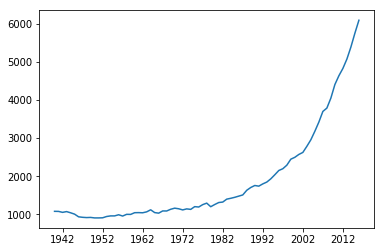

In [11]:
plt.plot(one_country_df['gdp'])

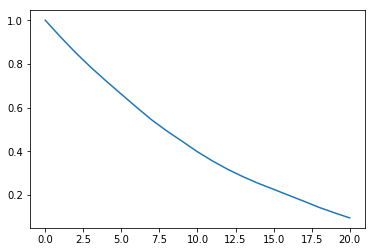

In [88]:
pd.Series(acf(one_country_df['gdp'],nlags = 20)).plot()

In [21]:
#### test stationarity on original gdp series
adfuller(one_country_df['gdp'], autolag = 'AIC', regression = 'ct')

(3.1938950736747325,
 1.0,
 11,
 65,
 {'1%': -4.105265484751935,
  '5%': -3.4803385352753753,
  '10%': -3.1678389485662266},
 681.3131984754282)

,Value,Label
0,-4.273417,Test Statistic
1,0.003459,p-value
2,0.000000,#Lags Used
3,71.000000,Number of Observations Used
4,-4.092293,Critical value for 1%
5,-3.474246,Critical value for 5%
6,-3.164308,Critical value for 10%


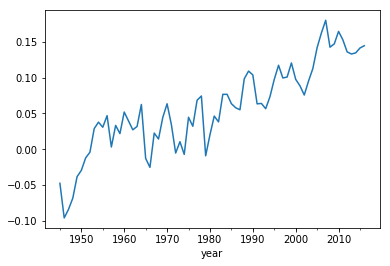

In [87]:
# here is my detrended series !! significant at 1% ----> ELLER?!?!

log_gdp = one_country_df['gdp'].apply(lambda x: np.log(x))
#rt_gdp = one_country_df['gdp'].apply(lambda x: x**.5)
rolling_mean = log_gdp.rolling(window = 6).mean()
gdp_detrended_with_log = log_gdp - rolling_mean
gdp_detrended_with_log.plot()
gdp_detrended_with_log.dropna(inplace=True)
#adfuller(gdp_detrended_with_log, autolag = 'AIC', regression = 'ct')

useful_values_raw = adfuller(gdp_detrended_with_log, autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

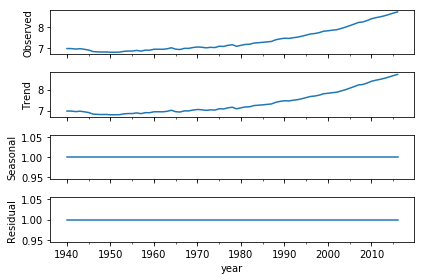

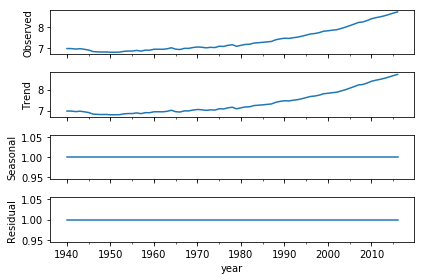

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
# try different models
log_gdp.interpolate(inplace = True)
decomposition = seasonal_decompose(log_gdp, model = 'multiplicative')
decomposition.plot()

In [61]:
decomposition = seasonal_decompose(log_gdp, model = 'multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

,Value,Label
0,-9.922279e+00,Test Statistic
1,3.375423e-15,p-value
2,0.000000e+00,#Lags Used
3,7.500000e+01,Number of Observations Used
4,-4.084850e+00,Critical value for 1%
5,-3.470743e+00,Critical value for 5%
6,-3.162275e+00,Critical value for 10%


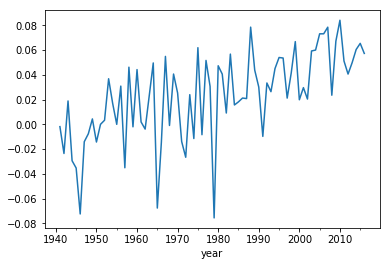

In [98]:
#### a different way to try to make series stationary, but i don't know if this works....

log_gdp_diff = log_gdp - log_gdp.shift()
log_gdp_diff.plot()

log_gdp_diff.dropna(inplace=True)
useful_values_raw = adfuller(log_gdp_diff, autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

In [89]:
lag_acf = acf(gdp_detrended_with_log, nlags=20)
lag_pacf = pacf(gdp_detrended_with_log, nlags=20)

Text(0.5,1,'Autocorrelation Function')

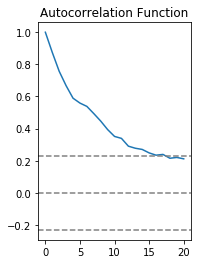

In [80]:
#Plot ACF  with gdp_detrended_with_log: gives P value  

### Isn't p=15 really high though?! 

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(gdp_detrended_with_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(gdp_detrended_with_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

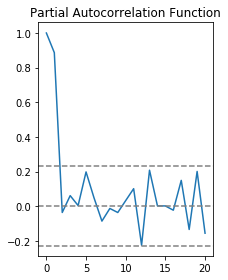

In [90]:
#Plot PACF gdp_detrended_with_log: gives 
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(gdp_detrended_with_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(gdp_detrended_with_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [1]:
##### create and fit the model
# p, d, q
model = ARIMA(log_gdp, order=(5,0,15))


#results_AR = model.fit(disp=0)  
#plt.plot(gdp_detrended_with_log)
#plt.plot(results_AR.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

NameError: name 'ARIMA' is not defined